In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# 25/Nov/2020 08:40

In [2]:
%%capture
# %matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import numpy as np


# Experiments
import run
from uniswap.model.sys_params import sys_params
from uniswap.model.state_variables import genesis_states
from uniswap.model.partial_state_update_block import PSUBs
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

In [3]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: multi_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (147437, 6, 1, 3)
Execution Method: single_proc_exec
Execution Mode: single_threaded
Total execution time: 9.70s
Execution in 9.9s


In [4]:
fees = [(1-(fee/1000))*100 for fee in sys_params['fee_numerator']]

## ANALYSIS

In [5]:
models = list()
for i in experiments['subset'].unique():
    models.append(experiments.loc[experiments['subset']==i,['DAI_balance', 'ETH_balance', 'UNI_supply']])
    
for df in models:
    df.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']
    df.reset_index(inplace=True)

In [6]:
UNI_df = pd.read_pickle('./uniswap_events.pickle')
real_history = UNI_df.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']
UNI_df

,transactionHash,transaction_index,transaction_sender,address,data,topics,blockNumber_dec,contract,event,contract_event,...,eth_delta,token_delta,uni_delta,eth_balance,token_balance,UNI_supply,invariant,block_timestamp,convert_ETH_rate,convert_DAI_rate
0,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9a...,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x06239653922ac7bea6aa2b19dc486b9361821d37712...,6629139,DAI,AddLiquidity,DAIAddLiquidity,...,30000000000000000000,5900000000000000000000,0,30000000000000000000,5900000000000000000000,0,177000000000000000000000000000000000000000,2018-11-02 10:27:36+00:00,201.546370,NaN
1,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9a...,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x00000000000000000000000000000000000000000000...,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,6629139,DAI,Transfer,DAITransfer,...,0,0,30000000000000000000,30000000000000000000,5900000000000000000000,30000000000000000000,177000000000000000000000000000000000000000,2018-11-02 10:27:36+00:00,201.546370,NaN
2,0xd53f01fc0cabbf4083da93a023ddb81de91320027077...,97,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427...,6629171,DAI,EthPurchase,DAIEthPurchase,...,-25326059253325791,5000000000000000000,0,29974673940746674209,5905000000000000000000,30000000000000000000,177000449620109111204145000000000000000000,2018-11-02 10:33:56+00:00,201.546370,NaN
3,0x53172898dbe437c784f7e4ac757087b28d1b06aa6b72...,53,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427...,6629177,DAI,EthPurchase,DAIEthPurchase,...,-10118429075406013,2000000000000000000,0,29964555511671268196,5907000000000000000000,30000000000000000000,177000629407442181233772000000000000000000,2018-11-02 10:35:47+00:00,201.546370,NaN
4,0x6cef57fd37d7a2602c1236ff080c61c37e10980c7e3b...,24,0x11e4857bb9993a50c685a79afad4e6f65d518dda,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee8885...,6629190,DAI,TokenPurchase,DAITokenPurchase,...,10000000000000000,-1964761376358359468,0,29974555511671268196,5905035238623641640532,30000000000000000000,177000806558499339943044863018842396120272,2018-11-02 10:38:18+00:00,201.546370,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147434,0x4c4d18cda4948561bf4df0e9cbfac4b7e9aedfea0285...,13,0xb14d1163e4b3cb18edf864b523ed42a87c21f68c,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee8885...,9193158,DAI,TokenPurchase,DAITokenPurchase,...,555227276348537093,-71129353666089377834,0,5013841555546109396965,661804343765215722063362,3304234867026987131356,3318182120410961321903054254127069667340496330,2019-12-31 23:31:34+00:00,129.324404,NaN
147435,0xf701ddbf48fc7ea18079f5bd9b7a29a5485abbee71ae...,29,0x614800dc2c7372f2595e66ca62cc2fa485f00c20,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee8885...,9193160,DAI,TokenPurchase,DAITokenPurchase,...,494601926415615730,-63347970222414138488,0,5014336157472525012695,661740995794993307924874,3304234867026987131356,3318191802096709075939561492313859130956275430,2019-12-31 23:31:44+00:00,129.324404,NaN
147436,0x06257f58f391b2fa9201cf4fc09e668f1e0b03c59b96...,27,0xffbfdb803d38d794b5785ee0ac09f83b429d11b5,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427...,9193211,DAI,EthPurchase,DAIEthPurchase,...,-2425103627055529511,312610256829251059712,0,5011911053845469483184,662053606051822558984586,3304234867026987131356,3318153786409383294318328983695028281242201824,2019-12-31 23:45:49+00:00,129.324404,NaN
147437,0x31597ad640ab1728b74d1835b6a10d61f5d33e1c49dd...,17,0x004dc6cb71104f64098fe70825516d2075cfa030,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c3

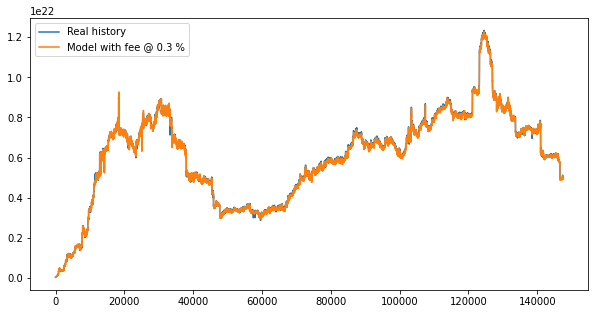

In [7]:
nmodels = len(models)

fig, axs = plt.subplots(figsize=(10,5))

plt.close()

axs.plot(real_history['real_ETH_balance'], label='Real history')

for i in range(nmodels):
    axs.plot(models[i]['model_ETH_balance'], label='Model with fee @ {:.1f} %'.format(fees[i]))

axs.legend(loc='upper left')
fig

In [8]:
df = experiments

prev_dai = pd.Series([np.nan]).append(df['DAI_balance'][:-1]).reset_index(drop=True)
prev_eth = pd.Series([np.nan]).append(df['ETH_balance'][:-1]).reset_index(drop=True)
df['delta_dai'] = df['DAI_balance'].diff()
df['delta_eth'] = df['ETH_balance'].diff()
df['istrade'] = (df['delta_dai'] > 0) != (df['delta_eth'] > 0)
df['volume'] = abs(df[df['istrade']]['delta_dai'])
df['volume'] = df['volume'].fillna(0)
df = df.drop(columns=['delta_dai','delta_eth','istrade'])

In [9]:
def ExpMovingAverage(values, window):
        weights = np.exp(np.linspace(-1., 0., window))
        weights /= weights.sum()
        a =  np.convolve(values, weights, mode='full')[:len(values)]
        a[:window] = a[window]
        return a

In [10]:
plot_data = experiments.copy()
plot_data[['DAI_balance',
           'ETH_balance',
           'UNI_supply',
           'volume']] = plot_data[['DAI_balance',
                                   'ETH_balance',
                                   'UNI_supply',
                                   'volume']]*1E-18
plot_data['ETH_price_DAI'] = plot_data['DAI_balance'] / plot_data['ETH_balance']
plot_data['UNI_price_DAI'] = 2 * plot_data['DAI_balance'] / plot_data['UNI_supply']

a = 0.5 * plot_data['ETH_price_DAI'][0] + 0.5 * plot_data['ETH_price_DAI']
plot_data['50_50_hodler_value'] = a.values

a = plot_data['50_50_hodler_value']/plot_data['50_50_hodler_value'][0] - 1
plot_data['50_50_hodler_return'] = a.values

a = plot_data['UNI_price_DAI']/plot_data['UNI_price_DAI'][0] - 1
plot_data['UNI_hodler_return'] = a.values

a = plot_data['ETH_price_DAI']/plot_data['ETH_price_DAI'][0] - 1
plot_data['ETH_hodler_return'] = a.values

plots = list()

for i in plot_data['subset'].unique():
    plots.append(plot_data[plot_data['subset'] == i])
for df in plots:
    df.reset_index(inplace=True)
    
plot_data

,DAI_balance,ETH_balance,UNI_supply,simulation,subset,run,substep,timestep,delta_dai,delta_eth,istrade,volume,ETH_price_DAI,UNI_price_DAI,50_50_hodler_value,50_50_hodler_return,UNI_hodler_return,ETH_hodler_return
0,5900,30,30,0,0,1,0,0,NaN,NaN,False,0,196.667,393.333,196.667,0,0,0
1,5905,29.9747,30,0,0,1,1,1,5000000000000000000,-25326059253325791,True,5,197,393.667,196.833,0.000846544,0.000847458,0.00169309
2,5907,29.9646,30,0,0,1,1,2,2000000000000000000,-10118429075406013,True,2,197.133,393.8,196.9,0.00118536,0.00118644,0.00237072
3,5905.04,29.9746,30,0,0,1,1,3,-1964761376358359468,10000000000000000,True,1.96476,197.002,393.669,196.834,0.000851512,0.00085343,0.00170302
4,5903.07,29.9846,30,0,0,1,1,4,-1963452825230191574,10000000000000000,True,1.96345,196.87,393.538,196.769,0.000517996,0.000520642,0.00103599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737185,882704,6687.38,1524.62,0,4,4,1,147433,-91246630256892667630,768007460042967936,True,91.2466,131.995,1157.93,164.331,-0.164418,1.9439,-0.328837
737186,882623,6688.07,1524.62,0,4,4,1,147434,-81265852172279217123,684142486245984000,True,81.2659,131.97,1157.83,164.318,-0.164484,1.94363,-0.328967
737187,883067,6685.04,1524.62,0,4,4,1,147435,444226224928403685376,-3028136367295090697,True,444.226,132.096,1158.41,164.381,-0.164163,1.94511,-0.328325
737188,883067,6685.04,1524.62,0,4,4,1,147436,0,0,False,0,132.096,1158.41,164.381,-0.164163,1.94511,-0.328325


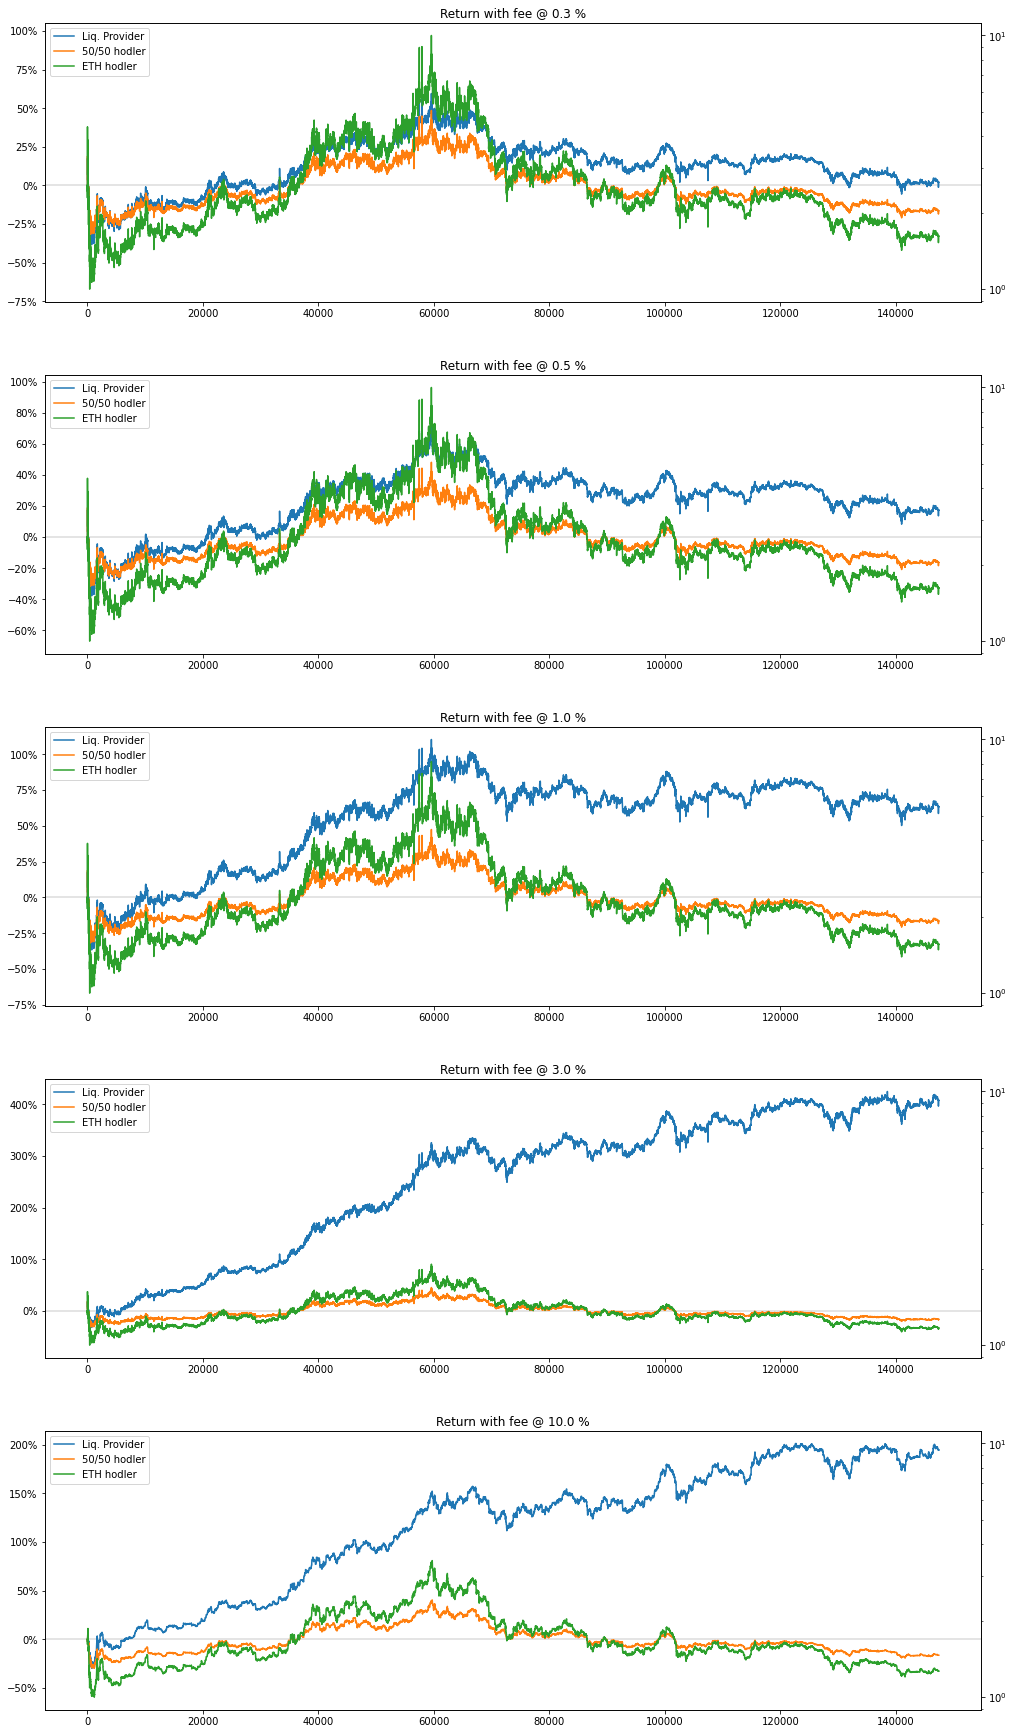

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml', embed_limit=50)
from matplotlib import cm
import matplotlib.ticker as ticker

nplots = len(plots)

fig, axs = plt.subplots(ncols=1, nrows=nplots,
                        figsize=(15,5*nplots))

plt.close()

for i in range(nplots):
    axs[i].axhline(0, color='gainsboro')
    ema = ExpMovingAverage(plots[i]['UNI_hodler_return'], 1)
    axs[i].plot(ema, label=f'Liq. Provider')
    axs[i].plot(plots[i]['50_50_hodler_return'], label=f'50/50 hodler')
    axs[i].plot(plots[i]['ETH_hodler_return'], label=f'ETH hodler')
    axs[i].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    axs[i].yaxis.tick_right()
    axs[i].legend(loc='upper left')
    axs[i].set_title('Return with fee @ {:.1f} %'.format(fees[i]))
    sec_ax = axs[i].twinx()
#     sec_ax.plot(plot_data.loc[i]['volume'], label='Volume')
    sec_ax.set_yscale('log')
    
fig.tight_layout(pad=4.0)
fig